In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d  # For smoothing

from numba import jit, njit


In [2]:
def v_img_singleside(W, N, min_l):
    arr_z = np.linspace(min_l, W+min_l, N)
    arr_V = - 1./(2*np.abs( 2*(arr_z)/min_l ))
    return arr_z, arr_V  

def v_img(d, zrange, N):
    arr_V = []
    arr_z = np.linspace(-zrange, zrange, N)
    for z in arr_z:
        V = 0
        nf = 15000
        n_Z = np.linspace( -nf, nf, 2*nf+1)
        for n in n_Z:
            if n != 0:
                V += ( 1./(2*np.abs(n)) - 1./(2.*np.abs(n+z/d + .000000000)) )
        if z < 0:
            arr_V.append(V)
        else:
            arr_V.append(V)
    return arr_z, np.asarray(arr_V)

def corr_dis(L, W, a, xic):
    Nx = int(L/a)
    Ny = int(W/a)
    Vxy = np.random.normal(0, 1., size=(Ny, Nx))/(a) + 1j*0.0
    
    kkVxy = np.fft.fft2(Vxy)
    kx = 2*np.pi * np.fft.fftfreq(kkVxy.shape[1],d=a)
    ky = 2*np.pi * np.fft.fftfreq(kkVxy.shape[0],d=a)
    kx, ky = np.meshgrid(kx,ky)
    
    kVxy = np.multiply(kkVxy, np.exp( - .125 * (xic)**2. * (kx**2.+ky**2.)  ) ) * (xic)/np.sqrt(2.)
    
    #xlong = W/4.
    #xavg = (xic + xlong)/2.
    #kVxy = np.multiply(kkVxy, np.exp( - .125**3. * xic**4. * (kx**4.+ky**4.)  ) ) * (xavg/2.)/np.sqrt(2.)
    #kVxy += np.multiply(kkVxy, np.exp( - .125 * (xlong)**2. * (kx**2.+ky**2.)  ) ) * (xavg/2.)/np.sqrt(2.)
    
    Vxy = np.fft.ifft2(kVxy)
    Vxy = Vxy - np.sum(Vxy)/(1.*Nx*Ny)

    return Vxy

In [3]:
nIMG = 0

#Function to re-import the data and parameters from target file
# Read the parameters
params_sys = {}
with open('G_%d.dat' % (nIMG), 'r') as f:
    for line in f:
        if line.startswith("#"):
            key, value = line[1:].strip().split(" = ")
            params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
        else:
            break

t, W, L, BandW0, alpha, xic, plate_distance, epsilon_r, ei, ef, Ne, iter_dis, Ncores = params_sys.values()

l0 = np.sqrt(568/BandW0*8.) * 10**(-3.) # sqrt( \hbar^2/(2m*)/(\hbar J)) here I took \hbar^2/(2m*) = 568 nm^2 meV (GaAs) and \hbar J = BW/8 in micron!
B0 = 4.14*10**3. / (l0 * 10**3.)**2. #in T, as 2\pi \hbar/e 1/a^2

alpha = 2*alpha #the kwant definition I used is actually 1/2 alpha, because in the magnetic phase is included (yi+yj) = 2 if i&j are nearest neighbour!

#ANOTHER FACTOR OF 2 IN THE DEFINITION OF Vimg! this justify why I need to take at least .5*IMG

d = W + 2*plate_distance
dis = .06/(BandW0/8.)
lB = 1./np.sqrt(2*np.pi*alpha)
omB0 = 4*np.pi*alpha

# Read the data
data = pd.read_csv('G_%d.dat' % (nIMG), sep=' ', comment='#')

energies = data['Energies'].to_numpy()
G0 = data['G0'].to_numpy()
GIMG = data['GIMG'].to_numpy()


In [4]:
arr_z, Vimg = v_img_singleside(W, int(W), plate_distance)
#arr_z, Vimg = v_img(d, W/2., int(W))
#IMG = 40*(1.44/(BandW0/8))/(epsilon_r*l0*d) #double-plate image charge energy constant in meV
IMG = 35*(1.44/(BandW0/8))/(epsilon_r*l0*plate_distance) #single-plate image charge energy constant in meV
Vimg = Vimg + (np.amax(Vimg)-np.amin(Vimg))/2*0 - np.amax(Vimg)

minV = IMG*np.amin(Vimg)

In [5]:
print( l0, plate_distance, lB, xic)
print(.25*IMG, .5*IMG/np.abs( plate_distance/lB + 2 ), omB0, dis)

0.6740919818541087 0.0012566370614359175 0.12632375554921296 15.957691216057308
593405.5249930131 590468.6081266627 125.33141373155001 48.0


In [6]:
# Second Plot Functions

def fermi_f(T, E, dE):
    if np.abs(E/T) < 100.:
        if dE/T < 1.:
            dF = - np.exp(E/T) / (np.exp(E/T) + 1.)**2. / T * dE
        else:
            dF = 1.
    else:
        dF = 0
    return dF

def finite_temp(T, N, G, energies):
    W = []
    E = []
    half_N = N // 2
    num_points = len(G)
    for n in range(num_points):
        weighted_sum = 0
        norm_factor = 0
        for i in range(-half_N, half_N + 1):
            index = n + i
            if 0 <= index < num_points:
                weight = fermi_f(T, energies[n] - energies[index], energies[n] - energies[n-1] if n > 0 else 1)
                weighted_sum += G[index] * weight
                norm_factor += weight
        W.append(weighted_sum / norm_factor if norm_factor != 0 else 0)
        E.append(energies[n])
    return np.array(W), np.array(E)


mu_bohr = 0.86 # Bohr magneton meV x T e\hbar^2/2m

G0T, energiesT =  G0, energies
GIMGT, energiesTIMG = GIMG, energies


# Define a threshold: small fraction of max(fX)
threshold_shift_IMGT = .001
threshold_shift_0T = .0001
# Find the first index where fX exceeds the threshold
nonzero_indices_IMGT = np.where(GIMGT > threshold_shift_IMGT)[0]
Eshift_IMGT = energiesT[nonzero_indices_IMGT[-1]]
# Find the first index where fX exceeds the threshold
nonzero_indices_0T = np.where(G0T > threshold_shift_0T)[0]
Eshift_0T = energiesT[nonzero_indices_0T[-1]]

Et = .5*IMG/np.abs( plate_distance/lB + 2 )/ omB0
E_targ = 1.5
indx_timg = np.argmin( np.abs((energiesT-Eshift_IMGT) / omB0 - E_targ+.2) )
indx_t0 = np.argmin( np.abs((energiesT -Eshift_0T) / omB0 - E_targ) )


T0 = omB0/70
N0 = 50

iter_T = 100
dT = omB0/10 /iter_T

ref_dGIMG = []
ref_dG0 = []
arr_T = []
for nT in range(iter_T):
    T = T0 +dT*nT
    arr_T.append(T)

    G0T, energiesT = finite_temp(T, N0, G0, energies -Eshift_0T)
    GIMGT, energiesTIMG = finite_temp(T, N0, GIMG, energies-Eshift_IMGT)

    dG0T_dE = np.gradient(G0T, energiesT)
    dGIMGT_dE = np.gradient(GIMGT, energiesT)
    
    indx_plato =  np.argmin( np.abs( (energiesT -Eshift_0T) - (omB0-omB0**2/32*(2*1**2+2*1+1)) ) )
    
    #ref_dG0.append( np.amin(np.abs(dG0T_dE[indx_plato:len(energiesT)])) )
    #ref_dGIMG.append( np.amin(np.abs(dGIMGT_dE[indx_plato:len(energiesT)])) )
    
    ref_dG0.append( dG0T_dE[indx_t0] )
    ref_dGIMG.append( dGIMGT_dE[indx_timg] )
    
    #smoothed_data = gaussian_filter1d(dGIMGT_dE, sigma=1.)  # Adjust sigma based on noise level
    # 1. Find peaks
    """peaks, properties = find_peaks(smoothed_data, height=np.amax(smoothed_data)/2, prominence=10)  # Threshold at 100 for big peaks
    # 2. Compute FWHM for the big peaks
    results_half = peak_widths(smoothed_data, peaks, rel_height=0.75)
    # Extract widths and peak positions
    fwhm_values = results_half[0]  # FWHM widths
    peak_positions = peaks  # Index positions of peaks
    average_fwhm = np.mean(fwhm_values)  
    #ref_dGIMG.append( average_fwhm )"""
    
    #ref_dGIMG.append( smoothed_data[indx_timg] )

    
    #smoothed_data = gaussian_filter1d(dG0T_dE, sigma=1.)
    # 1. Find peaks
    """peaks, properties = find_peaks(smoothed_data, height=np.amax(dG0T_dE)/2, prominence=10)  # Threshold at 100 for big peaks
    # 2. Compute FWHM for the big peaks
    results_half = peak_widths(smoothed_data, peaks, rel_height=0.75)
    # Extract widths and peak positions
    fwhm_values = results_half[0]  # FWHM widths
    peak_positions = peaks  # Index positions of peaks
    average_fwhm = np.mean(fwhm_values)  
    #ref_dG0.append( average_fwhm )"""
    
    #ref_dG0.append( smoothed_data[indx_t0] )
    
ref_dGIMG = np.asarray(ref_dGIMG)
ref_dG0 = np.asarray(ref_dG0)
arr_T = np.asarray(arr_T)
    

In [7]:
indx_plato =  np.argmin( np.abs( (energiesT -Eshift_0T) - .5*(omB0-omB0**2/32*(2*1**2+2*1+1)) ) )

print(Et, dT, indx_plato, len(energiesT))


4711.257860630215 0.12533141373155002 399 400


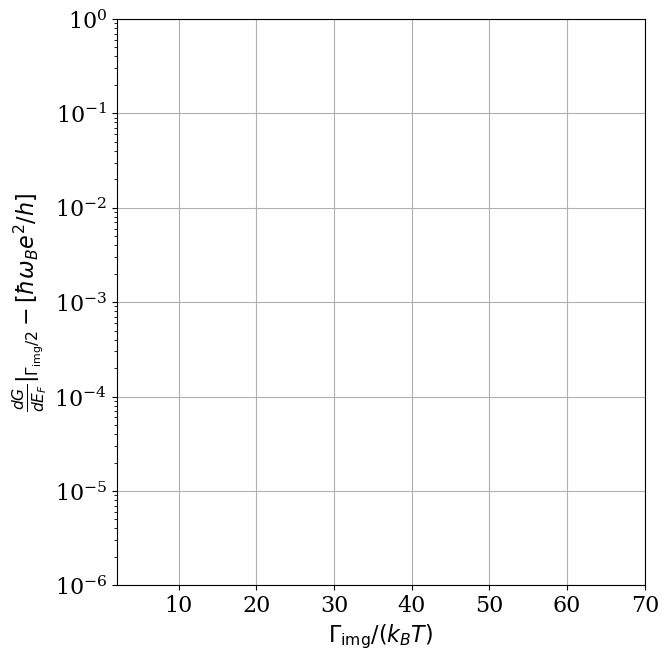

In [8]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

Et = .5*IMG/np.abs( plate_distance/lB + 2 )

#invT_ref = 1/11  # conversion from 1 meV to K, assuming omega_B=1 meV

invT_ref = omB0

ax1.plot( invT_ref/(arr_T), (arr_T*ref_dGIMG), color='red', linewidth=3)
ax1.plot( invT_ref/(arr_T), (arr_T*ref_dG0), color='black', linewidth=2, linestyle='--')


ax1.set_ylabel(r"$\frac{dG}{dE_F}|_{\Gamma_{\rm img}/2} - [\hbar \omega_Be^2/h]$", fontdict=font)
#ax1.set_xlabel(r"$\hbar \omega_B/(k_B T)$", fontdict=font)
ax1.set_xlabel(r"$\Gamma_{\rm img}/(k_B T)$", fontdict=font)

#ax1.set_ylim((1e-0, 5e1))  # Adjust the lower limit to avoid log(0) issues
ax1.set_xlim((2, 70))

ax1.set_yscale('log')  # Set log scale on y-axis

ax1.set_ylim((1e-6, 1e0))

ax1.grid()

plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))

plt.show()

(0.0, 1.0)

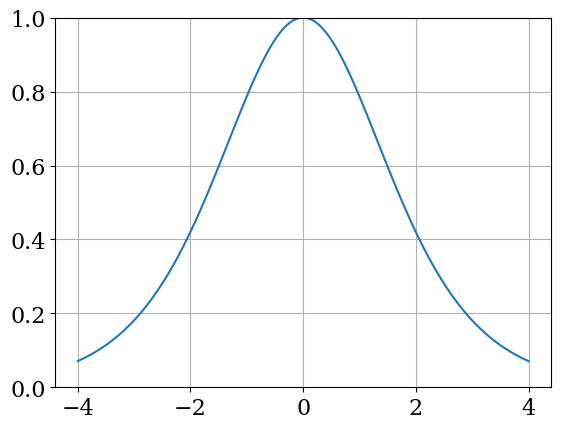

In [9]:
T = omB0/4
#f = np.exp( (energies-Eshift_0T - omB0)/T) / (np.exp((energies-Eshift_0T - omB0)/T) + 1.)**2. / T
#plt.plot( (energies-Eshift_0T)/omB0, f/np.amax(f))
arr_x = np.linspace(-4,4,100)
f = np.exp( (arr_x)/1) / (np.exp((arr_x)/1) + 1.)**2. / 1
plt.plot(arr_x, f/np.amax(f))
#plt.yscale('log')
plt.grid()
plt.ylim((0,1))



In [10]:
# Second Plot Functions
def fermi_f(T, E, dE):
    if np.abs(E/T) < 100.:
        if dE/T < 1.:
            dF = - np.exp(E/T) / (np.exp(E/T) + 1.)**2. / T * dE
        else:
            dF = 1.
    else:
        dF = 0
    return dF

def finite_temp(T, N, G, energies):
    W = []
    E = []
    half_N = N // 2
    num_points = len(G)
    for n in range(num_points):
        weighted_sum = 0
        norm_factor = 0
        for i in range(-half_N, half_N + 1):
            index = n + i
            if 0 <= index < num_points:
                weight = fermi_f(T, energies[n] - energies[index], (energies[n] - energies[n-1]) if n > 0 else 1)
                weighted_sum += G[index] * weight
                norm_factor += weight
        W.append(weighted_sum / norm_factor if norm_factor != 0 else 0)
        E.append(energies[n])
    return np.array(W), np.array(E)


mu_bohr = 0.86 # Bohr magneton meV x T e\hbar^2/2m

G0T, energiesT =  G0, energies
GIMGT, energiesTIMG = GIMG, energies

indx_timg = np.argmin( np.abs((energiesT) / omB0 - 1.3) )
indx_t0 = np.argmin( np.abs((energiesT +minV/4) / omB0 - 1.3) )

Et = .5*IMG/np.abs( plate_distance/lB + 2 )
T = omB0/50000
N0 = 50


G0T, energiesT = finite_temp(T, N0, G0, energies)
GIMGT, energiesTIMG = finite_temp(T, N0, GIMG, energies)

dG0T_dE = np.gradient(G0, energies)
#dG0T_dE, energiesT = finite_temp(T, N0, dG0T_dE, energies)


#dG0T_dE = gaussian_filter1d( (dG0T_dE), sigma=1.) 
#dG0T_dE = np.exp( dG0T_dE*np.log(10) )

dGIMGT_dE = np.gradient(GIMG, energies)
#dGIMGT_dE, energiesT = finite_temp(T, N0, dGIMGT_dE, energies)


#dGIMGT_dE = gaussian_filter1d( (dGIMGT_dE), sigma=1.) 
#dGIMGT_dE = np.exp( dGIMGT_dE*np.log(10) )




In [11]:
# Define a threshold: small fraction of max(fX)
threshold_shift_IMGT = .0001
threshold_shift_0T = .0001

# Find the first index where fX exceeds the threshold
nonzero_indices_IMGT = np.where(GIMGT > threshold_shift_IMGT)[0]
Eshift_IMGT = energiesT[nonzero_indices_IMGT[-1]]

# Find the first index where fX exceeds the threshold
nonzero_indices_0T = np.where(G0T > threshold_shift_0T)[0]
Eshift_0T = energiesT[nonzero_indices_0T[-1]]


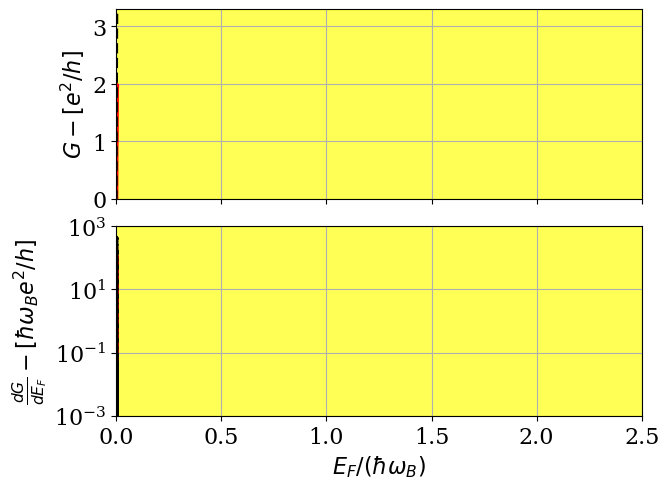

In [12]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# First subplot
ax1.plot(energies / omB0, 1 * np.ones(energies.size), linestyle=':', color='red')
for i in range(2, 7):
    ax1.plot(energies / omB0, i * np.ones(energies.size), linestyle=':', color='red')
ax1.plot( (energiesT-Eshift_IMGT) / omB0, GIMGT, color='red', linewidth=3)
ax1.plot( (energiesT -Eshift_0T) / omB0, G0T, color='black', linewidth=2, linestyle='--')


Et = .5*IMG/np.abs( plate_distance/lB + 2 )

"""ax1.plot( ( Et )/ omB0, 1, color='red', marker='o', markersize=12)
ax1.plot( (Et +omB0)/ omB0, 2, color='red', marker='o', markersize=12)
ax1.plot( (Et +2*omB0)/ omB0, 3, color='red', marker='o', markersize=12)
ax1.plot( (Et +3*omB0)/ omB0, 4, color='red', marker='o', markersize=12)
ax1.plot( (Et +4*omB0)/ omB0, 5, color='red', marker='o', markersize=12)"""

ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
#ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)
ax1.set_xlim((np.amin(energiesT)/ omB0,np.amax(energiesT)* BandW0 / 8.))



max0 = np.amax(np.abs(dG0T_dE))*0+1
maximg = np.amax(np.abs(dGIMGT_dE))*0+1
ax2.plot( (energiesT-Eshift_IMGT) / omB0, (dGIMGT_dE)/maximg, color='red', linewidth=2, linestyle='-')
ax2.plot( (energiesT-Eshift_0T) / omB0, (dG0T_dE)/max0, color='black', linewidth=2, linestyle='--')

ax2.set_ylabel(r"$\frac{dG}{dE_F} - [\hbar \omega_Be^2/h]$", fontdict=font)
ax2.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)


xmin = 0
xmax = 2.5

ax1.set_ylim((.0, 3.3))
ax1.set_xlim((xmin, xmax))

ax2.set_ylim((1e-3, 1e3))  # Adjust the lower limit to avoid log(0) issues
ax2.set_xlim((xmin, xmax))

ax2.set_yscale('log')  # Set log scale on y-axis


ax1.grid()
ax2.grid()
ax1.set_xticklabels([])

plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 120 / 25.4)

# Define shaded regions' x-intervals
om0 = -omB0**2/32*(2*0**2+2*0+1)
om1 = omB0-omB0**2/32*(2*1**2+2*1+1)
om2 = omB0*2-omB0**2/32*(2*2**2+2*2+1)
shaded_regions = [(om0/omB0, om0/omB0 + Et / omB0), (om1/omB0, om1/omB0 + Et / omB0), (om2/omB0, om2/omB0 + Et / omB0)]

# Loop to add shaded areas and vertical boundary lines
for x_start, x_end in shaded_regions:
    ax1.axvspan(x_start, x_end, color='yellow', alpha=0.3)  # Shaded area in ax1
    ax2.axvspan(x_start, x_end, color='yellow', alpha=0.3)  # Shaded area in ax2
    ax1.axvline(x_start, color='black', linewidth=1)  # Left boundary
    ax1.axvline(x_end, color='black', linewidth=1)  # Right boundary
    ax2.axvline(x_start, color='black', linewidth=1)  # Left boundary
    ax2.axvline(x_end, color='black', linewidth=1)  # Right boundary


#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('GR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))




plt.show()

Average FWHM (excluding noise peaks): 3.3595525610505206


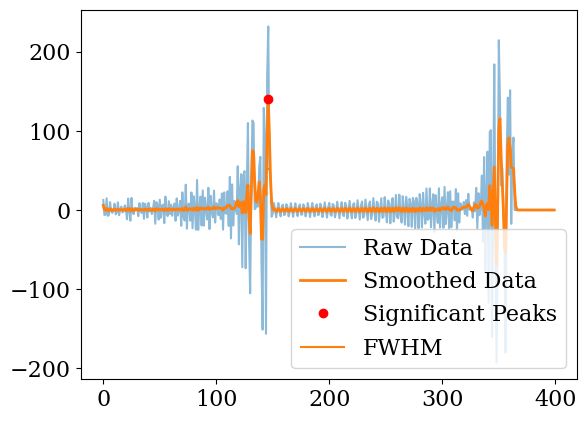

In [13]:
# 1. Smooth the noisy data (Gaussian filter)
smoothed_data = gaussian_filter1d(dGIMGT_dE, sigma=1)  # Adjust sigma based on noise level

# 2. Find peaks with prominence filtering
peaks, properties = find_peaks(smoothed_data, height=np.amax(dGIMGT_dE)/2, prominence=10)  # Adjust height & prominence

# 3. Compute FWHM for the selected peaks
results_half = peak_widths(smoothed_data, peaks, rel_height=0.5)

# Extract FWHM values
fwhm_values = results_half[0]

# 4. Compute the average FWHM
average_fwhm = np.mean(fwhm_values)
print(f"Average FWHM (excluding noise peaks): {average_fwhm}")

# 5. Plot results
plt.plot(dGIMGT_dE, label="Raw Data", alpha=0.5)  # Noisy data
plt.plot(smoothed_data, label="Smoothed Data", linewidth=2)  # Smoothed curve
plt.plot(peaks, smoothed_data[peaks], "ro", label="Significant Peaks")  # Mark big peaks
plt.hlines(results_half[1], results_half[2], results_half[3], color="C1", label="FWHM")  # FWHM lines
plt.legend()
plt.show()

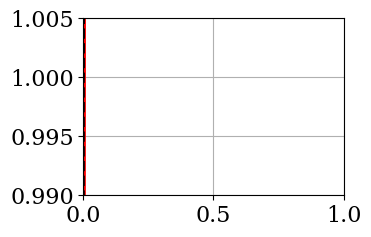

In [14]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
# First subplot

ax1.plot( (energiesT - Eshift_IMGT) / omB0, GIMGT, color='red', linewidth=3)
ax1.plot( (energiesT - Eshift_0T) / omB0, G0T, color='black', linewidth=2, linestyle='--')

#ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
#ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)
#ax1.set_xlim((np.amin(energiesT)/ omB0,np.amax(energiesT)* BandW0 / 8.))

ax1.set_ylim((.99, 1.005))
ax1.set_xlim((0, 1.))

Et = .5*IMG/np.abs( plate_distance/lB + 2 )

ax1.plot( (Et)/ omB0, 1, color='red', marker='o', markersize=12)


ax1.grid()


plt.tight_layout()
plt.gcf().set_size_inches(80 / 25.4, 50 / 25.4)
#plt.savefig('zoomGR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('zoomGR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))

plt.show()

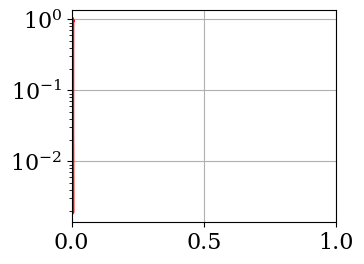

In [15]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
# First subplot

ax1.plot( (energiesT - Eshift_IMGT) / omB0, np.abs(GIMGT - 1), color='red', linewidth=3)

#ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
#ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)
#ax1.set_xlim((np.amin(energiesT)/ omB0,np.amax(energiesT)* BandW0 / 8.))

ax1.set_xlim((0, 1.))

Et = .5*IMG/np.abs( plate_distance/lB + 2 )

ax1.plot( (Et)/ omB0, 1, color='red', marker='o', markersize=12)
ax1.set_yscale('log')  # Set log scale on y-axis


ax1.grid()


plt.tight_layout()
plt.gcf().set_size_inches(80 / 25.4, 60 / 25.4)
#plt.savefig('zoomGR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('zoomGR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))

plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\h'
<>:23: SyntaxWarning: invalid escape sequence '\h'
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_87789/4197348701.py:23: SyntaxWarning: invalid escape sequence '\h'
  ax1.set_xlabel("$E_F/(\hbar\omega_B)$", fontdict=font)


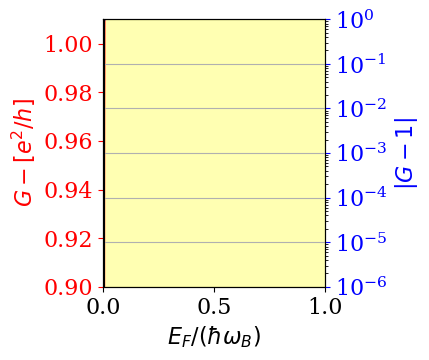

In [16]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and primary axis
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# First plot (red curve, left y-axis)
ax1.plot((energiesT - Eshift_IMGT) / omB0, GIMGT, color='red', linewidth=3, label='GIMGT')
ax1.plot((energiesT - Eshift_0T) / omB0, G0T, color='black', linewidth=2, linestyle='--', label='G0T')
ax1.set_ylabel("$G - [e^2/h]$", fontdict=font)
ax1.set_xlabel("$E_F/(\hbar\omega_B)$", fontdict=font)
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='red')
ax1.set_ylim((.9, 1.01))
ax1.set_xlim((0, 1))


# Compute the x-position for shading
Et = .5 * IMG / np.abs(plate_distance / lB + 2)
om0 = -omB0**2/32*(2*0**2+2*0+1)
ax1.axvspan(om0/ omB0, (om0+Et) / omB0, color='yellow', alpha=0.3)  # Add shaded area with low opacity
ax1.axvline((Et) / omB0, color='black', linewidth=1)

# Create a second y-axis for the second plot
ax2 = ax1.twinx()

# Second plot (blue curve, right y-axis)
ax2.plot((energiesT - Eshift_IMGT) / omB0, np.abs(GIMGT - 1), color='blue', linewidth=2, label='|GIMGT - 1|')
ax2.plot((energiesT - Eshift_0T) / omB0, np.abs(G0T - 1), color='black', linestyle='-', linewidth=2)

ax2.set_yscale('log')
ax2.set_ylabel("$|G - 1|$", fontdict=font)
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim((1e-6, 1e0))



ax2.grid()

plt.tight_layout()
plt.gcf().set_size_inches(80 / 25.4, 80 / 25.4)

plt.show()

In [17]:
alpha_scaling = .0000001

detIMG = GIMGT*GIMGT + alpha_scaling*(dGIMGT_dE*dGIMGT_dE) #/ (energiesT-0*Eshift_IMGT)**2
rhoxyIMG = np.divide( np.abs(GIMGT), detIMG)
rhoxxIMG = np.divide( np.abs(dG0T_dE), detIMG)

det0 = G0T*G0T + alpha_scaling*dG0T_dE*dG0T_dE
rhoxy0 = np.divide( np.abs(G0T), det0)
rhoxx0 = np.divide( np.abs(dG0T_dE), det0)


/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_87789/985084812.py:19: RuntimeWarning: divide by zero encountered in divide
  ax1.plot( omB0/(energiesT-Eshift_IMGT) , rhoxyIMG, color='red', linewidth=3)
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_87789/985084812.py:20: RuntimeWarning: divide by zero encountered in divide
  ax1.plot( omB0/(energiesT -Eshift_0T), rhoxy0, color='black', linewidth=2, linestyle='--')
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_87789/985084812.py:22: RuntimeWarning: divide by zero encountered in divide
  ax1.plot( omB0/(energiesT-Eshift_IMGT) , 1e5*alpha_scaling*rhoxxIMG, color='red', linewidth=3)
/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_87789/985084812.py:23: RuntimeWarning: divide by zero encountered in divide
  ax1.plot( omB0/(energiesT -Eshift_0T), 1e5*alpha_scaling*rhoxx0, color='black', linewidth=2, linestyle='--')


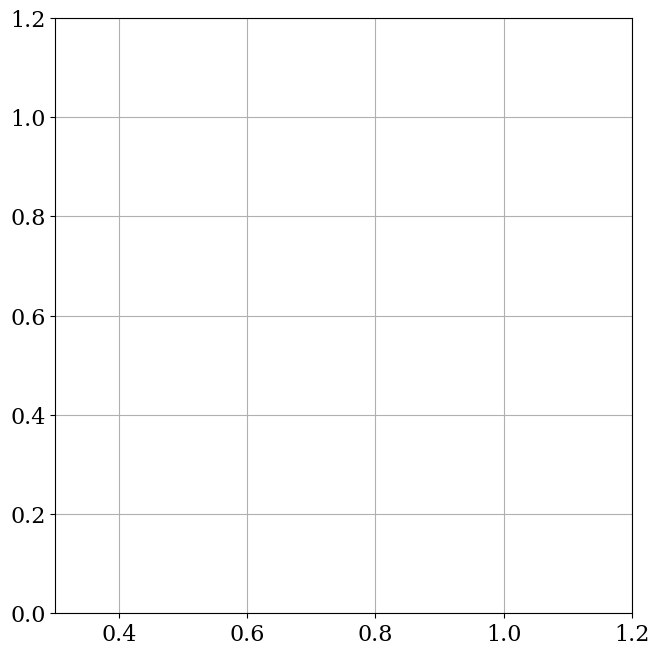

In [18]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
# First subplot

ax1.plot( omB0/(energiesT-Eshift_IMGT) , rhoxyIMG, color='red', linewidth=3)
ax1.plot( omB0/(energiesT -Eshift_0T), rhoxy0, color='black', linewidth=2, linestyle='--')

ax1.plot( omB0/(energiesT-Eshift_IMGT) , 1e5*alpha_scaling*rhoxxIMG, color='red', linewidth=3)
ax1.plot( omB0/(energiesT -Eshift_0T), 1e5*alpha_scaling*rhoxx0, color='black', linewidth=2, linestyle='--')

#ax1.set_ylabel(r"$G - [e^2/h]$", fontdict=font)
#ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$", fontdict=font)
#ax1.set_xlim((np.amin(energiesT)/ omB0,np.amax(energiesT)* BandW0 / 8.))

ax1.set_ylim((0, 1.2))
ax1.set_xlim((0.3, 1.2))

#ax1.plot( (1.*IMG * lB*l0*(1)**.5 + .5*omB0+minV/4 + dis)/ omB0, 1, color='red', marker='o', markersize=12)


ax1.grid()


plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)
#plt.savefig('zoomGR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.svg' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))
#plt.savefig('zoomGR_Nx%d_Ny%d_BW%.2f_dis%.2f_xic%.2f_IMG%.2f_alpha%.2f_W%dL%d_pltdist%d_T%.3f.pdf' % (L, W, BandW0, dis, xic, IMG, alpha, W, L, plate_distance, T0))

plt.show()

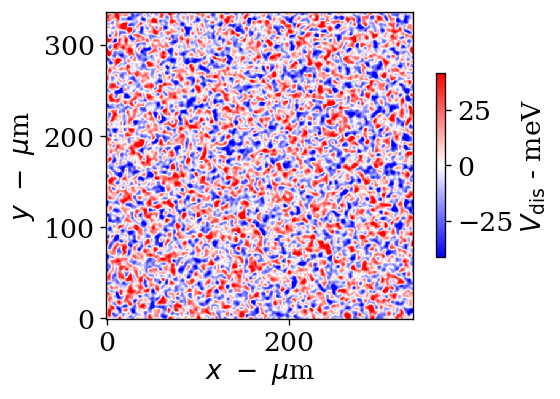

In [19]:


# Disorder plot (in rotated axis for the paper figure)
Vdis = corr_dis(int(params_sys["L"]), int(params_sys["W"]), 1, params_sys["xic"])
# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('blue_white_red', ['blue', 'white', 'red'])

# Create vectors and meshgrid
xvec = np.linspace(0, L-1, int(L))
yvec = np.linspace(0, W-1, int(W))
X, Y = np.meshgrid(xvec, yvec)


font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 16,
        }

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Plotting
fig_W, ax_W = plt.subplots(dpi=120, figsize=(4, 4))

maxV = np.amax(dis*np.abs(Vdis))*.5
vmin = -maxV  # Set the minimum value for colormap
vmax = maxV   # Set the maximum value for colormap
Wmap_plot = ax_W.pcolormesh( Y.T*l0, X.T*l0, (Vdis.real*dis).T, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
cbar = fig_W.colorbar(Wmap_plot,shrink=0.6)
cbar.set_label(r'$V_{\rm dis}$ - meV', fontdict=font)  # Add label to colorbar

# Axis labels
ax_W.set_xlabel(r'$x ~ - ~ \mu$m', fontdict=font)
ax_W.set_ylabel(r'$y ~ - ~ \mu$m', fontdict=font)
ax_W.set_aspect('equal')

# Additional array calculation
#sigmaXX = L / .1
#arr_omImg = np.multiply(np.tile(Vimg, (int(L), 1)).T, np.exp(-(X-L/2.+.5)**2. / (2.*(sigmaXX)**2.)))

plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 80*(L/W) / 25.4)
#plt.savefig("Vdis.svg")
#plt.savefig("Vdis_dis%.3f_xic%.2f.svg" % (dis,xic))
#plt.savefig("Vdis_dis%.3f_xic%.2f.pdf" % (dis,xic))

#plt.savefig("Vdis_dis%.3f_xic%.2f.png" % (dis,xic), dpi=300)

# Show plot
plt.show()